The goal of this notebook is to **use Google's GTFS data to find out how many trains are operating in the NYC Subway at any given time**. Along the way, we will also how frequency changes throughout the train schedule and examine how frequency interacts with ridership numbers.

[MTA Developer Tools](https://new.mta.info/developers). The google data for the mta should be all that we need. There's weekday, saturday, and sunday service so only need to worry about those times. Additionally, there's data on the buses, LIRR and Metro North in there, too.
- [mta metrics dashboard](https://metrics.mta.info/?subway/customerjourneytimeperformance)

[time frequency](https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_services#Train_frequency_charts) breakdown

Some notes about the results:
- the routes change by day of week (for example the M not running its whole route on the weekends)
- some routes include service changes (the 7 and 7 express both count as the 7)
- this also includes late nights where the routes can change dramatically (e.g.: the 5 train doesn't leave the BX at night)
- two routes don't run on the weekends: the B and W

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")
import warnings
warnings.filterwarnings(action='ignore')
import folium
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import tab20
from functions import *

In /Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be re

## Functions

# Schedule Data

In [2]:
routes_df = pd.read_csv("data/google_transit/routes.txt")
stop_times_df = pd.read_csv("data/google_transit/stop_times.txt")
stops_df = pd.read_csv("data/google_transit/stops.txt")

## Frequency Data 
(that I made)

In [3]:
first_stop_in_trip = pd.read_csv("saved_data/first_stop_in_trip.csv", index_col=0)
average_trip_time_per_service = pd.read_csv("saved_data/average_trip_time_per_service.csv", index_col=0)
hourly_route_trip_freq = pd.read_csv("saved_data/hourly_route_trip_freq.csv", index_col=0)
trip_interval_route_freq = pd.read_csv("saved_data/trip_interval_route_freq.csv", index_col=0)
hourly_station_ridership = pd.read_csv("saved_data/hourly_station_ridership.csv", index_col=0)
route_frequency_by_day = pd.read_csv("saved_data/route_frequency_by_day.csv", index_col=0)
station_info_w_frequency = pd.read_csv("saved_data/station_info_w_frequency.csv", index_col=0)
stations_df = pd.read_csv("saved_data/stations_df.csv", index_col=0)

In [4]:
# sorting the trip interval data by service
# sorting train_time_interval by time of day
time_of_day_sorting = {'Late Night': 0, 'Rush Hour AM': 1, 'Midday': 2
                                     , 'Rush Hour PM': 3, 'Evening': 4, 'Weekend': 5}
trip_interval_route_freq = trip_interval_route_freq.sort_values(by= ['route_id', 'train_time_interval']
                                    , key=lambda x: x.map(time_of_day_sorting)).reset_index(drop=True)

## Removing SIR 

In [5]:
station_info_w_frequency = station_info_w_frequency[station_info_w_frequency['Borough']!='SI']

# Getting TPH for each Station
note that we're using stations for this analysis and not complexes

## Overall (non late night) Frequency

In [6]:
station_info_w_frequency

,GTFS Stop ID,Complex ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,stations_in_complex_count,trains_per_hour,hourly_trainset_area,capacity,mean_wait_time,Late Night,Weekend,Rush Hour AM,Midday,Rush Hour PM,Evening
0,R01,1,BMT,Astoria,Astoria-Ditmars Blvd,Q,N W,Elevated,1,9.63,5495.76,1308.5,6.2,3.3,5.0,12.2,13.3,13.0,8.2
1,R03,2,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,1,9.63,5495.76,1308.5,6.2,3.3,5.0,12.3,13.2,13.1,8.1
2,R04,3,BMT,Astoria,30 Av,Q,N W,Elevated,1,9.63,5495.76,1308.5,6.2,3.3,5.0,12.3,13.2,13.1,8.1
3,R05,4,BMT,Astoria,Broadway,Q,N W,Elevated,1,9.65,5507.08,1311.2,6.2,3.3,5.0,12.5,13.3,13.0,8.1
4,R06,5,BMT,Astoria,36 Av,Q,N W,Elevated,1,9.65,5504.81,1310.7,6.2,3.2,5.0,12.3,13.3,13.0,8.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,901,610,IRT,Lexington - Shuttle,Grand Central-42 St,M,S,Subway,3,12.40,3114.84,741.6,4.8,0.8,9.5,16.3,12.8,15.9,12.2
471,726,471,IRT,Flushing,34 St-Hudson Yards,M,7,Subway,1,14.40,6629.41,1578.4,4.2,3.9,10.3,24.0,12.8,20.0,13.1
472,Q05,475,IND,Second Av,96 St,M,Q,Subway,1,7.46,4255.37,1013.2,8.0,3.3,6.6,9.0,7.5,9.4,6.9
473,Q04,476,IND,Second Av,86 St,M,Q,Subway,1,7.44,4244.05,1010.5,8.1,3.3,6.6,8.8,7.6,9.3,6.9


Text(0, 0.5, 'Trains per Hour')

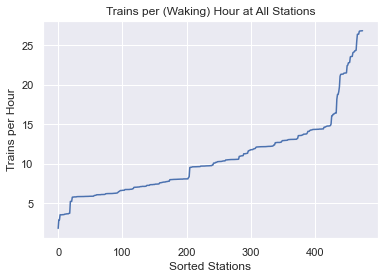

In [7]:
ax = station_info_w_frequency['trains_per_hour'].sort_values().plot(
    use_index=False, title="Trains per (Waking) Hour at All Stations")
ax.set_xlabel('Sorted Stations')
ax.set_ylabel('Trains per Hour')

### By Line 

In [8]:
# getting the average tph by line 
frequency_by_line = pd.DataFrame(station_info_w_frequency.groupby('Line')
                                 .mean()).sort_values(by='trains_per_hour')
frequency_by_line = frequency_by_line.drop(columns=['Complex ID', 'stations_in_complex_count', 'hourly_trainset_area'
                                            , 'capacity', 'mean_wait_time']).round(1).reset_index()

Text(0, 0.5, 'Trains per Hour')

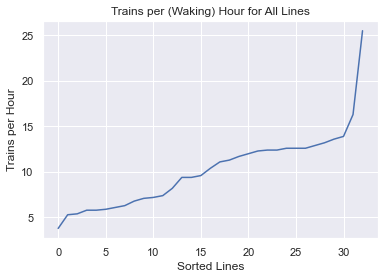

In [9]:
ax = frequency_by_line['trains_per_hour'].sort_values().plot(
    use_index=False, title="Trains per (Waking) Hour for All Lines")
ax.set_xlabel('Sorted Lines')
ax.set_ylabel('Trains per Hour')

### Mapping the Lines

In [10]:
num_categories = stations_df['Line'].nunique()
colors = [tab20(float(i)/num_categories) for i, _ in enumerate(stations_df['Line'].unique())]
hex_colors = [mpl.colors.rgb2hex(x, keep_alpha=True) for x in colors]
line_hex_colors = dict(zip(list(stations_df['Line'].unique()), hex_colors))

In [11]:
# I need to use folium for the map with circles
lines_map = folium.folium.Map([40.7128, -74.0061], zoom_start=10, tiles='cartodbpositron') # city hall coords
for idx in range(len(stations_df)):
     folium.Circle(
            location = (stations_df['GTFS Latitude'][idx], stations_df['GTFS Longitude'][idx]),
            radius = 150, 
            tooltip = stations_df['Line'][idx], 
            popup = stations_df['Stop Name'][idx],
#          TPH {station_complex_full_info.ridership[idx]} Riders per day"
            color=line_hex_colors[stations_df['Line'][idx]],
            fill=True,
            fill_opacity= 0.3
        ).add_to(lines_map)
# lines_map.save("./saved_data/Lines_map.html")

In [12]:
lines_map

### Plotting the Change in Frequency by Train Time Interval

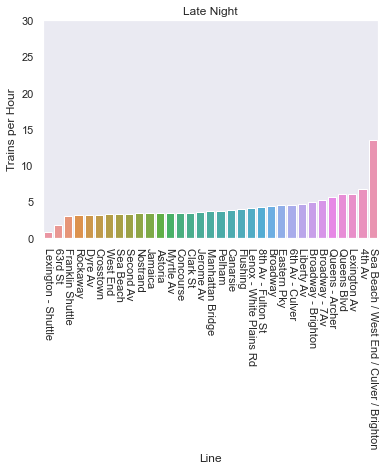

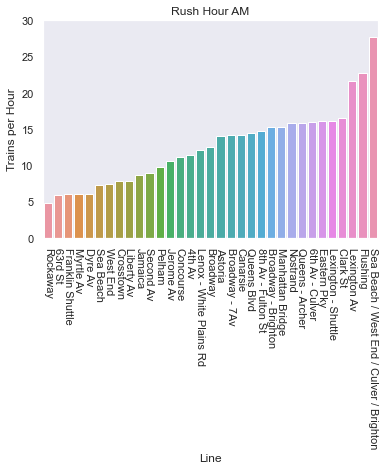

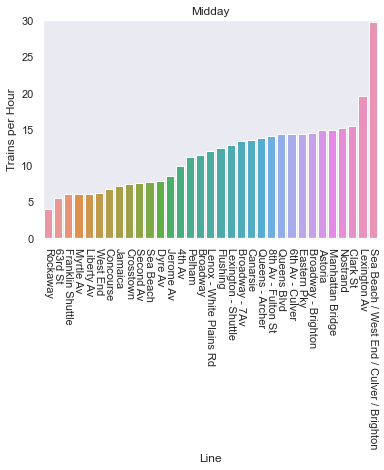

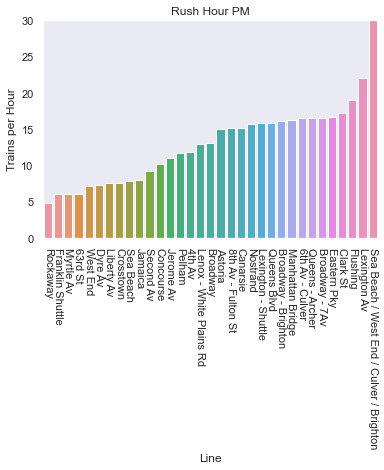

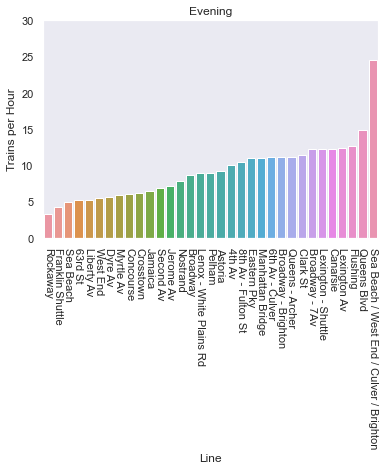

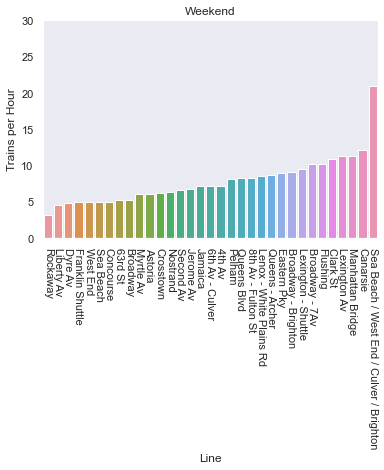

In [13]:
for interval in time_of_day_sorting.keys():
    ax = sns.barplot(data=frequency_by_line.sort_values(by=interval)
                                 , x = 'Line', y=interval)
#     ax.title(interval)
    ax.grid(axis='y')
    ax.set_ylim(ymin=0, ymax=30)
    ax.set_ylabel('Trains per Hour')
    ax.set_title(interval)
    plt.xticks(rotation=270)
    plt.show()

In [14]:
frequency_by_line

,Line,trains_per_hour,Late Night,Weekend,Rush Hour AM,Midday,Rush Hour PM,Evening
0,Rockaway,3.8,3.1,3.1,4.8,4.0,4.8,3.3
1,Franklin Shuttle,5.3,3.0,4.9,6.0,6.0,6.0,4.2
2,63rd St,5.4,1.8,5.2,5.9,5.5,6.1,5.3
3,Myrtle Av,5.8,3.4,6.0,6.0,6.0,6.0,5.9
4,Liberty Av,5.8,4.7,4.6,7.9,6.0,7.6,5.3
5,West End,5.9,3.3,4.9,7.4,6.2,7.2,5.5
6,Dyre Av,6.1,3.2,4.8,6.0,7.9,7.3,5.6
7,Sea Beach,6.3,3.3,4.9,7.3,7.7,7.8,5.0
8,Crosstown,6.8,3.2,6.2,7.8,7.5,7.6,6.2
9,Concourse,7.1,3.4,4.9,11.1,6.7,10.2,6.1
